# Data Challenge : Historical consumption regression for electricity supply pricing

## Introduction

In this notebook, we present our work using XGBoost regressor for the prediction of electicity supply pricing. We begin with importing data and the pre-processing steps with the help of the module "model" that we created. Then we have applied our model for prediction and we compare results for training and validation. In the end we have fine tunned our model to enhance the mean absolute score and we used the "early stop" to avoid overfitting. 

### Importings

In [1]:
# linear algebra
import numpy as np
import math
# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd 

from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from sklearn.model_selection import RandomizedSearchCV

import xgboost 
from xgboost import plot_importance


from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt


# local importing
from model import preprocessing

# 1. Data preparation

In [2]:
## Importing data

plt.style.use('fivethirtyeight')
#Import training data
inputFilePath = "./input_training_ssnsrY0.csv"
data_train = pd.read_csv(inputFilePath, delimiter = ',', skiprows = 0, index_col=[0])
id_train=data_train.timestamp

#Import testing data
inputFilePathTest = "./input_test_cdKcI0e.csv"
data_test = pd.read_csv(inputFilePathTest, delimiter = ',', skiprows = 0, index_col=[0])
id_test = data_test.index
# import targets
outputFilePath = "./output_training_Uf11I9I.csv"
y_data = pd.read_csv(outputFilePath, delimiter = ',', skiprows = 0, index_col=[0])

In [3]:
data=preprocessing.Data(data_train,data_test,y_data)
data.data_preprocessing()
X_train1,X_train2,X_test1,X_test2=data.get_data_split()
y_train1,y_train2=data.get_split_y_data()

C:\Users\youss\Desktop\docs_ml\time series\model\util\need.py:17: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  df['weekofyear'] = df.index.weekofyear


In [4]:
y_data=y_data.set_index(data_train.timestamp)

In [5]:
# training data
Date_split='2017-09-01'
X_train1,X_train2,y_train1,y_train2=X_train1.loc[:Date_split],X_train2.loc[:Date_split],\
y_train1.loc[:Date_split],y_train2.loc[:Date_split]

# validation data
X_val1 = X_train1.loc[Date_split:]
y_val1 = y_train1.loc[Date_split:]

X_val2 = X_train2.loc[Date_split:]
y_val2 = y_train2.loc[Date_split:]

# number of features
print(data.data_train.columns)

Index(['temp_1', 'temp_2', 'mean_national_temp', 'humidity_1', 'humidity_2',
       'consumption_secondary_1', 'consumption_secondary_2',
       'consumption_secondary_3', 'isHoliday', 'hour', 'month', 'year',
       'dayofmonth', 'quarter', 'weekofyear', 'dayofweek', 'isWeekend',
       'temp_1_smooth7D', 'temp_2_smooth7D', 'humidity_1_smooth7D',
       'humidity_2_smooth7D'],
      dtype='object')


Metric for the test defined in data challenge

In [6]:
# total consumption for site 1
T1=y_train1.sum() 
# total consumption for site 2
T2=y_train2.sum()
def wmae(y_actual, y_pred):
    return 2 * mean_absolute_error(y_actual*T1, y_pred*T2) / (T1+T2)

# 2. Model : XGBoost Regressor

In this section we will use the XGboost directly without fine tunning

In [7]:
X_test1.head()

,temp_1,mean_national_temp,humidity_1,consumption_secondary_1,consumption_secondary_2,consumption_secondary_3,isHoliday,hour,month,year,dayofmonth,quarter,weekofyear,dayofweek,isWeekend,temp_1_smooth7D,humidity_1_smooth7D
timestamp,,,,,,,,,,,,,,,,,
2017-11-01 00:00:00,6.5,8.8,91.0,190,126,177,1,0,11,2017,1,4,44,2,0,7.6,84.0
2017-11-01 01:00:00,6.8,8.7,89.0,189,116,172,1,1,11,2017,1,4,44,2,0,7.6,84.0
2017-11-01 02:00:00,6.8,8.7,88.0,195,117,175,1,2,11,2017,1,4,44,2,0,7.6,84.0
2017-11-01 03:00:00,5.8,8.6,90.0,197,115,171,1,3,11,2017,1,4,44,2,0,7.6,84.0
2017-11-01 04:00:00,5.0,8.5,90.0,198,115,174,1,4,11,2017,1,4,44,2,0,7.6,84.0


In [8]:
# RXGboost egression Model with default parameters
xgb = xgboost.XGBRegressor()

In [9]:
## prediction for Lille (1)
eval_set = [(X_val1, y_val1)]
xgb.fit(X_train1, y_train1, eval_set=eval_set, verbose=0)
y_pred1 = xgb.predict(X_test1)
# save data in a DataFrame format
y_pred1_df = pd.DataFrame(y_pred1, index=data_test.index, columns=['pred1']) 

In [10]:
# Calculat the mean absolute error between training and prediction data
y_train_pred1 = xgb.predict(X_train1)
error1 = mae(y_train1, y_train_pred1) ## mse for the training
print("Mean absolute errorfor training data: %f" % (error1))
## mae upon validation
y_pred_val= xgb.predict(X_val1)
error_val=mae(y_val1,y_pred_val)
print("Mean absolute error for validation data: %f" % (error_val))

Mean absolute errorfor training data: 2.571926
Mean absolute error for validation data: 2.787779


Feature Importances :  [0.00189386 0.00831435 0.00525019 0.02896011 0.08489134 0.66757137
 0.00457749 0.01401015 0.02409516 0.         0.0077586  0.
 0.08806274 0.00888274 0.         0.02594917 0.02978277]


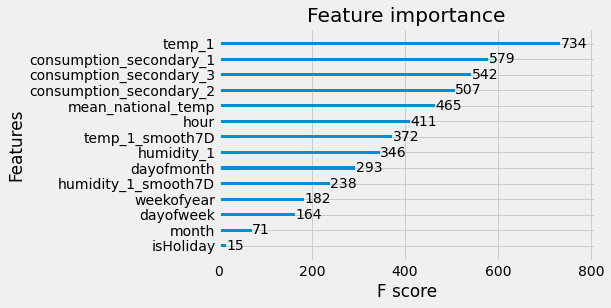

In [11]:
from xgboost import plot_importance
print("Feature Importances : ", xgb.feature_importances_)

# plot feature importance
plot_importance(xgb)
plt.show()

* The impact of removing non important features is very small

In [12]:
X_train1.columns

Index(['temp_1', 'mean_national_temp', 'humidity_1', 'consumption_secondary_1',
       'consumption_secondary_2', 'consumption_secondary_3', 'isHoliday',
       'hour', 'month', 'year', 'dayofmonth', 'quarter', 'weekofyear',
       'dayofweek', 'isWeekend', 'temp_1_smooth7D', 'humidity_1_smooth7D'],
      dtype='object')

In [13]:
# We will update out training data by selecting the importants features 
important_features=['temp_1',
                    'consumption_secondary_1',
                    'consumption_secondary_2', 
                    'consumption_secondary_3',
                    'mean_national_temp'     ,  
                    'hour'                   ,
                    'humidity_1'             ,
                    'dayofmonth'             , 
                    'temp_1_smooth7D'        ,
                    'humidity_1_smooth7D'    ,
                    'weekofyear'             ,
                    'dayofweek'              ,
                    'month'                  ,
                   'isHoliday']
X_train11 = X_train1[important_features]
xgb.fit(X_train11, y_train1)

# Calculat the mean absolute error between training and prediction data
y_train_pred1 = xgb.predict(X_train11)
error1 = mae(y_train1, y_train_pred1) ## mse for the training
print("mae for training data after removing non important features: %f" % (error1))

X_val11 = X_train11.loc[Date_split:]
y_pred_val= xgb.predict(X_val11)
error_val=mae(y_val1,y_pred_val)
print("mae for validation data fter removing non important features: %f" % (error_val))

mae for training data after removing non important features: 2.571926
mae for validation data fter removing non important features: 2.787779


* We got the same result after selecting important features 
*We will save the initiale features because we may avoid overfitting

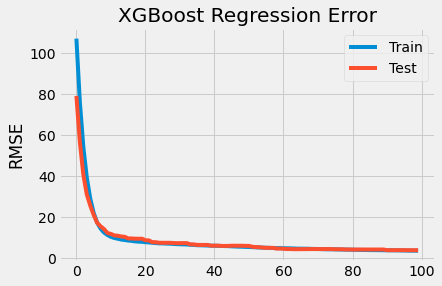

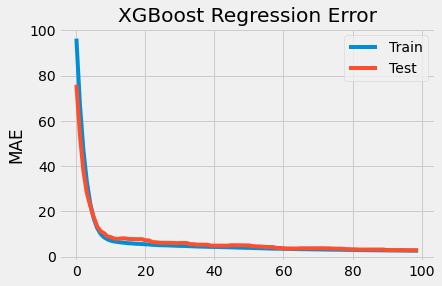

In [14]:
# fit model to training data
model = xgboost.XGBRegressor()
eval_set = [(X_train1, y_train1), (X_val1, y_val1)]
model.fit(X_train1,
          y_train1,
          early_stopping_rounds=80,
          eval_metric=["mae", "rmse"],
          eval_set=eval_set,
          verbose=0)

# make predictions for test data
y_pred = model.predict(X_test1)
predictions = [round(value) for value in y_pred]

# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['mae'])
x_axis = range(0, epochs)

# plot for rmse
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('RMSE')
plt.title('XGBoost Regression Error')
plt.show()

# plot for mae
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['mae'], label='Train')
ax.plot(x_axis, results['validation_1']['mae'], label='Test')
ax.legend()
plt.ylabel('MAE')
plt.title('XGBoost Regression Error')
plt.show()

* We have used early stopping to avoid overfitting
* We dont dispose of testing target so we can't use this technique in next prediction 
* Instead we will avoid overfitting by reducing the number of iteration to around 35 in next models

#### For the second location 2

In [15]:
## Prediction for Aix (2)
xgb.fit(X_train2, y_train2)
y_pred2 = xgb.predict(X_test2)
y_pred2_df = pd.DataFrame(y_pred2, columns=['pred2']).set_index(id_test)

In [16]:
y_train_pred2 = xgb.predict(X_train2)
error2= mae(y_train2, y_train_pred2) ## mse for the training
print("RMSE for training Data: %f" % (error2))

## Mae upon validation
y_pred_val2= xgb.predict(X_val2)
error_val2=mae(y_val2,y_pred_val2)
print("mean absolute error for validation data: %f" % (error_val2))

RMSE for training Data: 2.712563
mean absolute error for validation data: 2.823925


Feature Importances :  [0.00465169 0.00579838 0.0011868  0.01225627 0.24697387 0.08343361
 0.00360881 0.02864904 0.4347578  0.         0.01288804 0.
 0.06902951 0.00276829 0.         0.05932254 0.03467542]


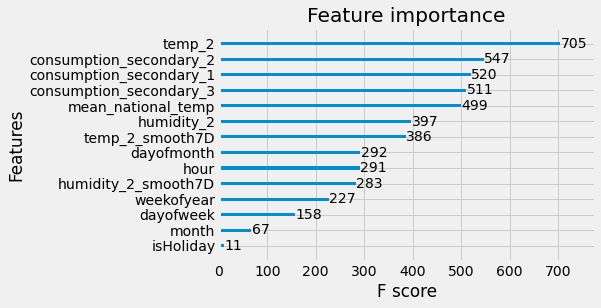

In [17]:
print("Feature Importances : ", xgb.feature_importances_)

# Plot feature importance
plot_importance(xgb)
plt.show()

In [18]:
# We will update out training data by selecting the importants features 
important_features=['hour',
                    'dayofweek',
                    'month',
                    'dayofmonth', 
                    'weekofyear',
                    'mean_national_temp',
                    'consumption_secondary_2',
                    'consumption_secondary_1',
                    'consumption_secondary_3',
                    'temp_2',
                    'humidity_2', 
                    'temp_2_smooth7D', 
                    'humidity_2_smooth7D']
X_train22=X_train2[important_features]
xgb.fit(X_train22, y_train2)
y_train_pred2 = xgb.predict(X_train22)
error2= mae(y_train2, y_train_pred2) ## mse for the training
print("RMSE for training Data: %f" % (error2))

## Mae upon validation
X_val22=X_val2[important_features]
y_pred_val2= xgb.predict(X_val22)
error_val2=mae(y_val2,y_pred_val2)

print("mean absolute error for validation data: %f" % (error_val2))
## We notice that the mse remains the same

RMSE for training Data: 2.679306
mean absolute error for validation data: 1.879408


In [19]:
## Erreur pour les deux sites
error= (error1*T1+ error2*T2)/(T1+T2)
print("WMAE : the  metric used in the challenge: %f" % (error))

WMAE : the  metric used in the challenge: 2.628019


In [20]:
## Create the submission csv file
sub2 = pd.concat([y_pred1_df, y_pred2_df], axis=1).set_index(id_test)
sub2.to_csv('submission_xgb.csv')

* resulting accuracy in the data challenge 19.45

# 3. Parameter tunning for XGBoost

For localisation 1

In [21]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
time_kfold = TimeSeriesSplit(n_splits=5)


## Hyper Parameter Optimization

params={
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
 "n_estimators"     : range(50,300,50),
 "max_depth"        : [ 2,3, 4, 5, 6, 8, 10, 12, 15],
 "min_child_weight" : [ 1, 3, 5, 7 ],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ],
 'metric': ['l2', 'auc']}

# We have used random search instead of grid search to optimise calculating time 
random_search=RandomizedSearchCV(xgb,
                                param_distributions=params,
                                n_iter=5,                           
                                n_jobs=-1, 
                                cv=time_kfold,
                                random_state=1)


In [22]:
random_search.fit(X_train1, y_train1)
random_search.best_params_

[00:23:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




{'n_estimators': 200,
 'min_child_weight': 1,
 'metric': 'l2',
 'max_depth': 10,
 'learning_rate': 0.1,
 'gamma': 0.0,
 'colsample_bytree': 0.7}

* we take the tunned parameters and we set the n_estimators to 25 so as to avoid overfitting


In [23]:
# time series cross validation
params={'n_estimators': 35,
 'min_child_weight': 1,
 'metric': 'l2',
 'max_depth': 10,
 'learning_rate': 0.1,
 'gamma': 0.0,
 'colsample_bytree': 0.7}

In [24]:
xgb = xgboost.XGBRegressor(**params)

In [25]:
## prediction for Lille (1)
eval_set = [(X_train1, y_train1), (X_val1, y_val1)]
xgb.fit(X_train1, y_train1, verbose=0)
y_pred1 = xgb.predict(X_test1)
y_pred1_df = pd.DataFrame(y_pred1, index=data_test.index, columns=['pred1'])

# the metric used to evaluate the model upon training data
xgb.fit(X_train1, y_train1, verbose=0)
pred1_train = xgb.predict(X_train1)
rmse = mae(y_train1, pred1_train) ## mse for the training
print("mean absolute error for training Data:", (rmse))
### for validation
## mae upon validation
y_pred_val= xgb.predict(X_val1)
error_val=mae(y_val1,y_pred_val)
print("mean absolute error for validation data:",error_val)
### test prediction
pred1 = xgb.predict(X_test1)
pred1_df = pd.DataFrame(pred1,index=X_test2.index, columns=['pred1'])

[00:24:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[00:24:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


mean absolute error for training Data: 4.56339033960498
mean absolute error for validation data: 3.7378247578938804


<AxesSubplot:xlabel='timestamp'>

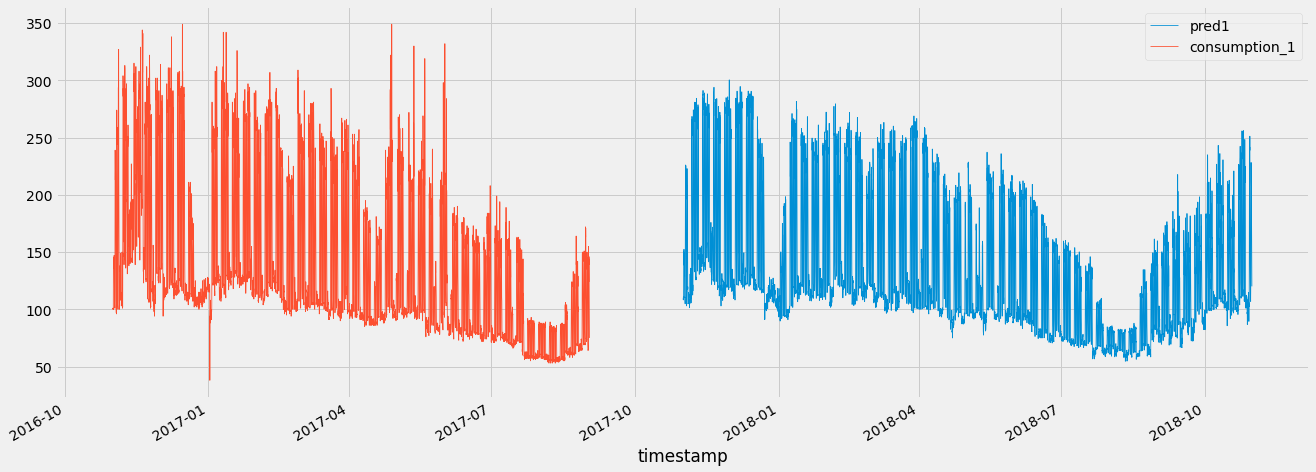

In [26]:
pred1_df.plot(figsize=(20,8), lw=0.8, legend=True)
y_train1.plot(figsize=(20,8), lw=0.8, legend=True)

For localisation 2

In [27]:
random_search.fit(X_train2, y_train2)
random_search.best_params_

[00:24:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




{'n_estimators': 200,
 'min_child_weight': 1,
 'metric': 'l2',
 'max_depth': 10,
 'learning_rate': 0.1,
 'gamma': 0.0,
 'colsample_bytree': 0.7}

In [28]:
param={'n_estimators': 35,
 'min_child_weight': 1,
 'metric': 'l2',
 'max_depth': 10,
 'learning_rate': 0.1,
 'gamma': 0.0,
 'colsample_bytree': 0.7}
xgb = xgboost.XGBRegressor(**param)

In [29]:
## prediction for Aix (2)
xgb.fit(X_train2, y_train2)
pred2 = xgb.predict(X_train2)

rmse = mae(y_train2, pred2) 
print("RMSE for training Data: %f" % (rmse))

### test prediction
pred2 = xgb.predict(X_test2)
pred2_df = pd.DataFrame(pred2, index=X_test1.index, columns=['pred2'])
## a supprimer 7.970530

[00:24:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


RMSE for training Data: 5.070140


<AxesSubplot:xlabel='timestamp'>

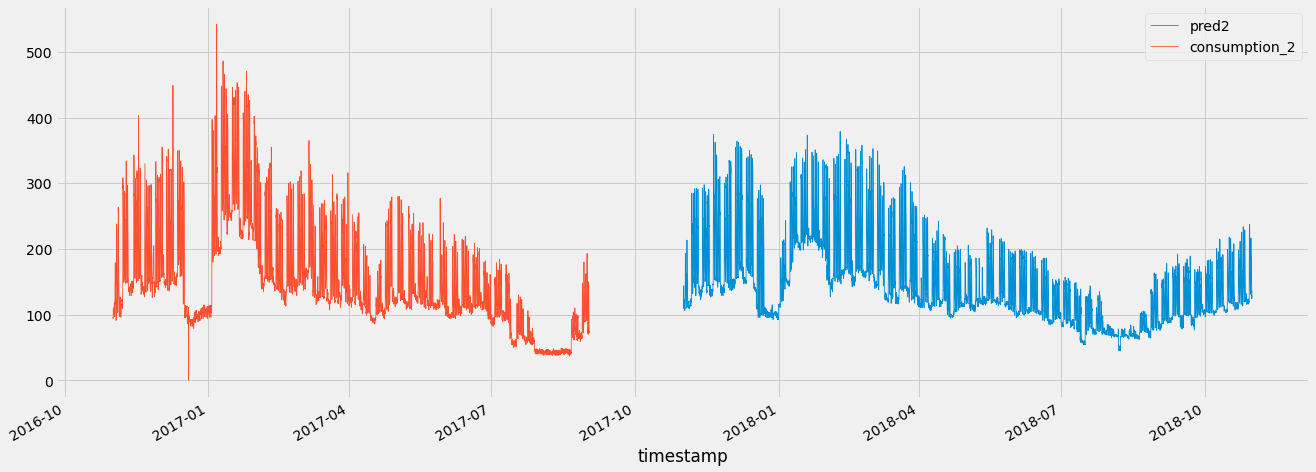

In [30]:
pred2_df.plot(figsize=(20,8), lw=0.8, legend=True)
y_train2.plot(figsize=(20,8), lw=0.8, legend=True)

In [31]:
sub3 = pd.concat([pred1_df, pred2_df], axis=1).set_index(id_test)
sub3.to_csv('submission_xgb_2.csv')

* Resulting accuracy in the data challenge 18.45 
* Ranking 31/90